## Background

In this notebook, I'll work through the first "Further Research" exercise at the end of [Chapter 4 of the Practical Deep Learning for Coders textbook](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb):

> Create your own implementation of Learner from scratch, **based on the training loop shown in this chapter.**

I've emphasized that this `Learner` implementation is basic, based on what we've learned in Chapter 4. I'll call my implementation `BasicLearner`, as it corresponds to the `BasicOptim` optimizer created in the chapter. I'll use my `BasicLearner` implementation to train a simple neural net on the `MNIST_SAMPLE` dataset.

## `MNIST_SAMPLE` Training Loop

I'll start by recreating the training loop in Chapter 4 to train a simple neural net to classify the handwritten digits 3s and 7s.

### Load and Prepare the Data

In [83]:
from fastai.vision.all import *

The `MNIST_SAMPLE` dataset is available through fastai's `URLs` which I download using `untar_data`.

In [84]:
path = untar_data(URLs.MNIST_SAMPLE)

In [85]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

Then stack the list of training set and validation set tensor images into 3-dimensional tensors.

In [86]:
stacked_threes = torch.stack([tensor(Image.open(o)) for o in (path/'train'/'3').ls().sorted()]).float()/255
stacked_sevens = torch.stack([tensor(Image.open(o)) for o in (path/'train'/'7').ls().sorted()]).float()/255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

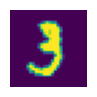

In [87]:
show_image(stacked_threes[0]);

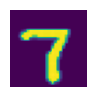

In [88]:
show_image(stacked_sevens[0]);

In [89]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]).float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]).float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

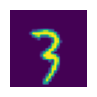

In [90]:
show_image(valid_3_tens[0]);

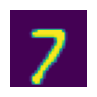

In [91]:
show_image(valid_7_tens[0]);

We then combine the training sets for 3s and 7s and "flatten" (not sure if that's the right term) the tensors so that each image's pixels are in a one-dimensional row.

In [92]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*stacked_threes.shape[0] + [0]*stacked_sevens.shape[0]).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

Then do the same for the validation sets:

In [93]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

We create training and validation datasets with the same structure as PyTorch's `Dataset`:

In [94]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [95]:
valid_dset = list(zip(valid_x, valid_y))
x,y = valid_dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

Then feed those datasets into fastai's `DataLoader`s:

In [96]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [97]:
valid_dl = DataLoader(valid_dset, batch_size=256)
valid_xb, valid_yb = first(valid_dl)
valid_xb.shape, valid_yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

### Create Our Model

For this exercise they have us create a simple neural net with a ReLU sandwiched between two linear functions. I have kept the number of intermediate activations (30) the same as the text

In [98]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

### Create a Loss Function

The loss function we will use does the following:

- Pass the model's activations through a sigmoid function so that they are between 0 and 1.
- When the target is 1 (the digit 3), take the difference between 1 and the activation. When the target is 0 (the digit 7), take the difference between 0 and the activation.
- Take the mean of the distance between activations and targets.

In [99]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

### Create a Function to Calculate Predictions, Loss and Gradients

The `calc_grad` function takes as inputs the independent and dependent data batches, passes them through the model to get the activations (predictions), calculates the batch's loss, and calls `backward` on the loss to calculate the weights' gradients:

In [100]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

### Create an Optimizer

The optimizer handles the calculation to step the weights and reset the gradients. When stepping the weights, the `.data` attribute of the parameters is used since PyTorch doesn't calculate gradients on it. The `zero_grad` method sets the gradients to 0 (`None`) so that they don't accumulate additively when the next epoch's gradients are calculated:

In [101]:
class BasicOptim:
  def __init__(self,params,lr): self.params,self.lr = list(params),lr

  def step(self, *args, **kwargs):
    for p in self.params: p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad = None

In [102]:
lr = 0.1

In [103]:
opt = BasicOptim(simple_net.parameters(), lr)

### Create a Function to Train One Epoch

For each training epoch:

- Get a batch from the training `DataLoader`.
- Calculate the activations, loss, and gradients.
- Step the weights in the direction opposite of the gradients.
- Reset the gradients to zero.

In [104]:
def train_epoch(model):
  for xb,yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

### Create a Function to Calculate a Metric for One Batch

The metric of choice in the chapter is accuracy, which is the mean of correctly predicted digits across the batch:

In [105]:
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

### Create a Function to Calculate the Metric for One Epoch

For each batch in the validation `DataLoader`, calculate the accuracy. Then, take the mean of all batch accuracy values as the accuracy for the epoch:

In [106]:
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

### Create a Function for the Training Loop

`train_model` takes a model, and number of epochs that you want to train the model for as inputs. For each epoch, it trains the model on the training set batches, and outputs the epoch's metric on the validation set batches:

In [107]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

### Train the Model

As is done in the text, I'll train the model for 40 epochs.

In [108]:
train_model(simple_net, 40)

0.5127 0.8013 0.9175 0.9419 0.957 0.9653 0.9672 0.9677 0.9687 0.9702 0.9726 0.9736 0.9745 0.9755 0.9755 0.9765 0.977 0.9785 0.9785 0.9785 0.9795 0.9799 0.9804 0.9809 0.9809 0.9814 0.9819 0.9819 0.9819 0.9824 0.9829 0.9829 0.9829 0.9829 0.9829 0.9829 0.9829 0.9829 0.9829 0.9829 

I get a similar starting and final accuracy as the example from the text.

## `BasicLearner` Class

My `BasicLearner` should recreate the training process performed in the above sections. I'll start by defining the inputs and outputs for an instance of this class:

### Inputs and Outputs

The fastai `Learner` requires the following inputs:

- `DataLoaders` with training and validation sets.
- The model we want to train with.
- An optimizer function.
- A loss function.
- Any metrics we want calculated.

The `Learner` outputs a table with the following information when a `fit(epochs, lr)` method is called. I've bolded the items that I'm going to show in the first iteration of my `Learner`:

- **Epoch #.**
- Training Loss.
- Validation Loss.
- **Metric.**
- Time.

With these inputs and outputs in mind, I'll write the `BasicLearner` class:


In [109]:
class BasicLearner:
  def __init__(self, dls, model, opt_func, loss_func, metric):
    self.dls = dls
    self.model = model
    self.opt_func = opt_func
    self.loss_func = loss_func
    self.metric = metric

  def calc_grad(self, xb, yb, model):
    preds = self.model(xb)
    loss = self.loss_func(preds, yb)
    loss.backward()

  def train_epoch(self):
    for xb,yb in self.dls.train:
      self.calc_grad(xb, yb, self.model)
      self.opt.step()
      self.opt.zero_grad()

  def validate_epoch(self):
    accs = [self.metric(self.model(xb), yb) for xb,yb in self.dls.valid]
    return round(torch.stack(accs).mean().item(), 4)

  def train_model(self, model, epochs):
    print("Epoch", self.metric.__name__, sep="\t")
    for i in range(self.epochs):
      self.train_epoch()
      print(i, self.validate_epoch(), sep="\t")

  def fit(self, epochs, lr):
    self.lr = lr
    self.epochs = epochs
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.train_model(self.model, self.epochs)

I'll combine my training and validation `DataLoader`s and confirm that they contain the correct number of tuples in their datasets:

In [110]:
dls = DataLoaders(dl, valid_dl)

In [111]:
len(dls.train.dataset)

12396

In [112]:
len(dls.valid.dataset)

2038

I'll create a fresh neural net to use as a from-scratch model during training:

In [113]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

I'll instantiate my `BasicLearner` class:

In [114]:
learn = BasicLearner(dls=dls,
                     model=simple_net,
                     opt_func=BasicOptim,
                     loss_func=mnist_loss,
                     metric=batch_accuracy)

And train the model:

In [115]:
learn.fit(40, 0.1)

Epoch	batch_accuracy
0	0.5068
1	0.814
2	0.9184
3	0.9419
4	0.9575
5	0.9648
6	0.9663
7	0.9677
8	0.9692
9	0.9707
10	0.9736
11	0.9736
12	0.9741
13	0.9755
14	0.9765
15	0.9775
16	0.978
17	0.9785
18	0.979
19	0.979
20	0.979
21	0.9795
22	0.9795
23	0.9804
24	0.9804
25	0.9809
26	0.9814
27	0.9819
28	0.9819
29	0.9819
30	0.9814
31	0.9819
32	0.9819
33	0.9824
34	0.9824
35	0.9829
36	0.9829
37	0.9829
38	0.9829
39	0.9829


Looks good! I'm getting similar starting and ending accuracy values as before.

## Improving the `BasicLearner` Class

Now that I've confirmed that my `BasicLearner` is able to train a neural net to get 98% accuracy classifying 3s and 7s, I would like to add a bit more functionality to the class.

First, I'd like to add a `predict` method to the learner which will take as input a tensor image, and then output the prediction, so that I can test if my model has truly learned how to classify 3s and 7s.

In [116]:
class BasicLearner:
  def __init__(self, dls, model, opt_func, loss_func, metric):
    self.dls = dls
    self.model = model
    self.opt_func = opt_func
    self.loss_func = loss_func
    self.metric = metric

  def calc_grad(self, xb, yb, model):
    preds = self.model(xb)
    loss = self.loss_func(preds, yb)
    loss.backward()

  def train_epoch(self):
    for xb,yb in self.dls.train:
      self.calc_grad(xb, yb, self.model)
      self.opt.step()
      self.opt.zero_grad()

  def validate_epoch(self):
    accs = [self.metric(self.model(xb), yb) for xb,yb in self.dls.valid]
    return round(torch.stack(accs).mean().item(), 4)

  def train_model(self, model, epochs):
    print("Epoch", self.metric.__name__, sep="\t")
    for i in range(self.epochs):
      self.train_epoch()
      print(i, self.validate_epoch(), sep="\t")

  def fit(self, epochs, lr):
    self.lr = lr
    self.epochs = epochs
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.train_model(self.model, self.epochs)

  def predict(self, x):
    prediction = self.model(x)
    prediction = prediction.sigmoid()
    label = "3" if prediction > 0.5 else "7"
    return prediction, label

I'll instantiate a new model and `BasicLearner` and train it again:

In [117]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [118]:
learn = BasicLearner(dls=dls,
                     model=simple_net,
                     opt_func=BasicOptim,
                     loss_func=mnist_loss,
                     metric=batch_accuracy)

In [119]:
learn.fit(40, 0.1)

Epoch	batch_accuracy
0	0.5073
1	0.8184
2	0.9194
3	0.9419
4	0.957
5	0.9638
6	0.9658
7	0.9672
8	0.9697
9	0.9706
10	0.9726
11	0.9741
12	0.9741
13	0.9755
14	0.976
15	0.9765
16	0.9765
17	0.978
18	0.978
19	0.978
20	0.9795
21	0.9795
22	0.9799
23	0.9809
24	0.9809
25	0.9814
26	0.9814
27	0.9814
28	0.9819
29	0.9814
30	0.9814
31	0.9824
32	0.9829
33	0.9829
34	0.9829
35	0.9829
36	0.9824
37	0.9824
38	0.9824
39	0.9824


With the model trained, I can see if it predicts an image of a 3 correctly:

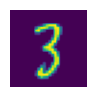

In [120]:
show_image(dls.valid.dataset[1][0].view(-1,28,28));

In [121]:
learn.predict(dls.valid.dataset[1][0])

(tensor([1.0000], grad_fn=<SigmoidBackward0>), '3')

The final piece that I'll add is a "training loss" column in the `fit` method's output during training. The training loss of each batch will be stored in a tensor, at the end of each epoch I'll calculate the mean loss value, print it out, and reset the loss tensor to 0.

In [139]:
class BasicLearner:
  def __init__(self, dls, model, opt_func, loss_func, metric):
    self.dls = dls
    self.model = model
    self.opt_func = opt_func
    self.loss_func = loss_func
    self.metric = metric

  def calc_grad(self, xb, yb, model):
    preds = self.model(xb)
    loss = self.loss_func(preds, yb)
    # store the loss of each batch
    # later to be averaged across the epoch
    self.loss = torch.cat((self.loss, tensor([loss])))
    loss.backward()

  def train_epoch(self):
    for xb,yb in self.dls.train:
      self.calc_grad(xb, yb, self.model)
      self.opt.step()
      self.opt.zero_grad()

  def validate_epoch(self):
    accs = [self.metric(self.model(xb), yb) for xb,yb in self.dls.valid]
    return round(torch.stack(accs).mean().item(), 4)

  def train_model(self, model, epochs):
    print("Epoch", "Train Loss", self.metric.__name__, sep="\t")
    for i in range(self.epochs):
      self.loss = tensor([])
      self.train_epoch()
      print(i, round(self.loss.mean().item(), 4), self.validate_epoch(), sep="\t\t")

  def fit(self, epochs, lr):
    self.lr = lr
    self.epochs = epochs
    self.opt = self.opt_func(self.model.parameters(), self.lr)
    self.train_model(self.model, self.epochs)

  def predict(self, x):
    prediction = self.model(x)
    prediction = prediction.sigmoid()
    label = "3" if prediction > 0.5 else "7"
    return prediction, label

In [140]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [141]:
learn = BasicLearner(dls=dls,
                     model=simple_net,
                     opt_func=BasicOptim,
                     loss_func=mnist_loss,
                     metric=batch_accuracy)

In [142]:
learn.fit(40, 0.1)

Epoch	Train Loss	batch_accuracy
0		0.3627		0.5229
1		0.1088		0.7715
2		0.0593		0.9111
3		0.0439		0.9389
4		0.0375		0.9516
5		0.0337		0.9629
6		0.0311		0.9653
7		0.0291		0.9667
8		0.0275		0.9672
9		0.0261		0.9687
10		0.025		0.9721
11		0.0241		0.9736
12		0.0233		0.9746
13		0.0225		0.9755
14		0.0219		0.9755
15		0.0213		0.976
16		0.0208		0.9765
17		0.0204		0.978
18		0.02		0.9785
19		0.0196		0.9785
20		0.0193		0.979
21		0.0189		0.979
22		0.0186		0.979
23		0.0184		0.9799
24		0.0181		0.9804
25		0.0178		0.9804
26		0.0176		0.9804
27		0.0174		0.9804
28		0.0172		0.9804
29		0.017		0.9814
30		0.0168		0.9824
31		0.0166		0.9824
32		0.0164		0.9829
33		0.0163		0.9829
34		0.0161		0.9829
35		0.016		0.9824
36		0.0158		0.9829
37		0.0157		0.9829
38		0.0155		0.9829
39		0.0154		0.9829


In [143]:
# check prediction again
learn.predict(dls.valid.dataset[1][0])

(tensor([1.0000], grad_fn=<SigmoidBackward0>), '3')

## Further Improvements

My `BasicLearner` is able to train a neural net classifying two digits to an accuracy of 98%. During training, it prints out the epoch number, training loss and metric. It also has a `predict` method to test its classification on new tensor images. While I'm happy with the result of this exercise, there are certainly numerous improvements and additions that can be made to expand this learner to match the functionality of the fastai `Learner` class.

I hope you enjoyed reading this blog post!